# COBA network

Download the Jupyter notebook: [COBA.ipynb](https://raw.githubusercontent.com/ANNarchy/CNS2023/master/src/notebooks/COBA.ipynb){target="_blank"} or run it directly on  [colab.](https://colab.research.google.com/github/ANNarchy/CNS2023/blob/master/src/notebooks/COBA.ipynb){target="_blank"}

In [1]:
#!pip install ANNarchy

This script reproduces the benchmark used in:

> Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., *J. Comput. Neurosci., 23, 3, 349–98*

based on the balanced network proposed by: 

> Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., *J. Neurosci., 25, 46, 10786–95*

The network is composed of 4000 neurons (3200 excitatory and 800 inhibitory), reciprocally connected with a probability of 0.02 (sparse connectivity).

The COBA model uses conductance-based IF neurons:

$$\tau \cdot \frac{dv (t)}{dt} = E_l - v(t) + g_\text{exc} (t) \, (E_\text{exc} - v(t)) + g_\text{inh} (t) \, (E_\text{inh} - v(t)) + I(t)$$

The discretization step has to be set to 0.1 ms:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ANNarchy import * 
clear()
setup(dt=0.1) 

ANNarchy 4.7 (4.7.2.5) on darwin (posix).


## Neuron definition

In [3]:
COBA = Neuron(
    parameters="""
        El = -60.0          : population
        Vr = -60.0          : population
        Erev_exc = 0.0      : population
        Erev_inh = -80.0    : population
        Vt = -50.0          : population
        tau = 20.0          : population
        tau_exc = 5.0       : population
        tau_inh = 10.0      : population
        I = 20.0            : population
    """,
    equations="""
        tau * dv/dt = (El - v) + g_exc * (Erev_exc - v) + g_inh * (Erev_inh - v ) + I

        tau_exc * dg_exc/dt = - g_exc
        tau_inh * dg_inh/dt = - g_inh
    """,
    spike = "v > Vt",
    reset = "v = Vr",
    refractory = 5.0
)

The neuron defines exponentially-decreasing conductance `g_exc` and `g_inh` for the excitatory and inhibitory conductances, respectively. It also defines a refractory period of 5 ms.

## Population

In [4]:
P = Population(geometry=4000, neuron=COBA)
Pe = P[:3200]
Pi = P[3200:]

We create a population of 4000 COBA neurons, and assign the 3200 first ones to the excitatory population and the 800 last ones to the inhibitory population.

It would have been equivalent to declare two separate populations as:

```python
Pe = Population(geometry=3200, neuron=COBA)
Pi = Population(geometry= 800, neuron=COBA)
```

but splitting a global population allows to apply methods to all neurons, for example when recording all spikes with a single monitor, or when initializing populations parameters uniformly:

In [5]:
P.v = Normal(-55.0, 5.0)
P.g_exc = Normal(4.0, 1.5)
P.g_inh = Normal(20.0, 12.0)

## Connections

The neurons are randomly connected with a probability of 0.02 (sparse connectivity). 

Excitatory neurons project on all other neurons with the target "exc" and a weight of 0.6, while the inhibitory neurons have the target "inh" and a weight of 6.7.

In [6]:
We= 0.6
Wi = 6.7
p = 0.02

Ce = Projection(pre=Pe, post=P, target='exc')
Ce.connect_fixed_probability(weights=We, probability=p)

Ci = Projection(pre=Pi, post=P, target='inh')
Ci.connect_fixed_probability(weights=Wi, probability=p)

In [7]:
compile()

After compilation, the weights are created and can be accessed like regular variables. This allows to visualize the connectivity matrices. 



In [8]:
exc_weights = Ce.w
print(exc_weights)

0.6


You will note that network stores a single weight value, as it would be a waste of RAM to store it multiple times. If you want unique values, make the weight values slightly random:

```python
Ce.connect_fixed_probability(weights=Normal(0.6, 0.01), probability=0.02)
```

Nevertheless, you can visualize the connectivity matrix with a built-in method:

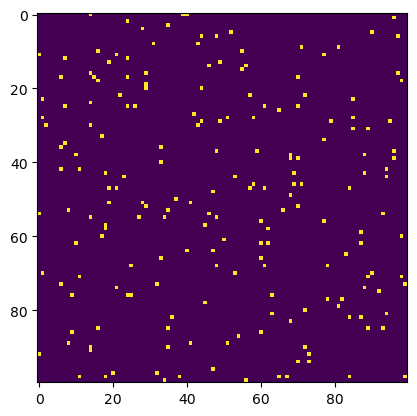

In [9]:
connectivitymatrix = Ce.connectivity_matrix()

plt.figure()
plt.imshow(connectivitymatrix[:100, :100])
plt.show()

## Simulation

We first define a monitor to record the spikes emitted in the whole population:

In [10]:
m = Monitor(P, ['spike'])

We can then simulate for 500 millisecond:

In [11]:
simulate(500.)

We retrieve the recorded spikes from the monitor:

In [12]:
data = m.get('spike')

and compute a raster plot from the data:

In [13]:
t, n = m.raster_plot(data)

`t` and `n` are lists representing for each spike emitted during the simulation the time at which it was emitted and the index the neuron which fired. The length of this list represents the total number of spikes in the population, so we can compute the population mean firing rate:

In [14]:
print('Mean firing rate in the population: ' + str(len(t) / 4000.) + 'Hz')

Mean firing rate in the population: 10.02025Hz


Finally, we can show the raster plot with pylab:

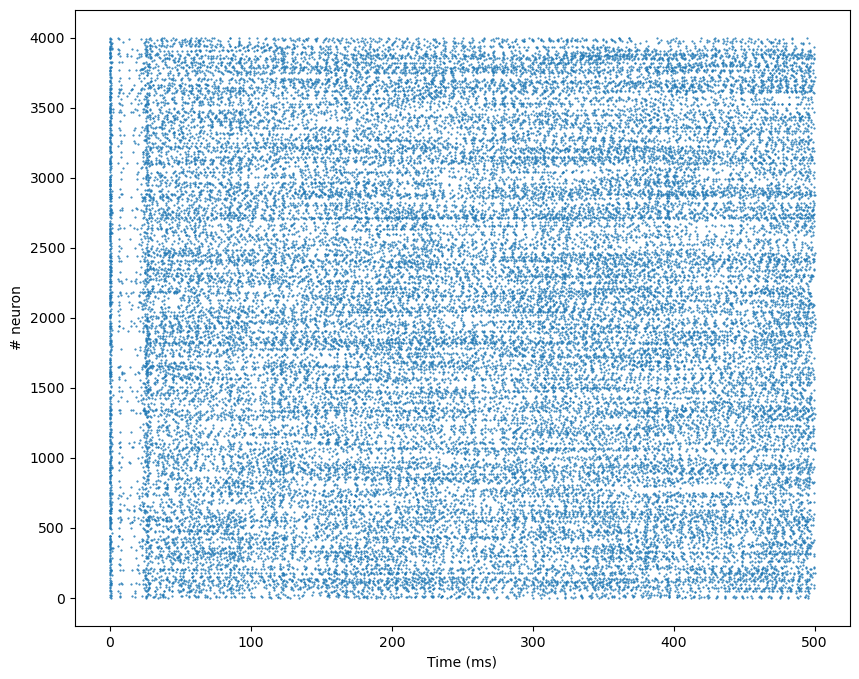

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(t, n, '.', markersize=1.0)
plt.xlabel('Time (ms)')
plt.ylabel('# neuron')
plt.show()

We can also plot the mean firing rate in the population over time:

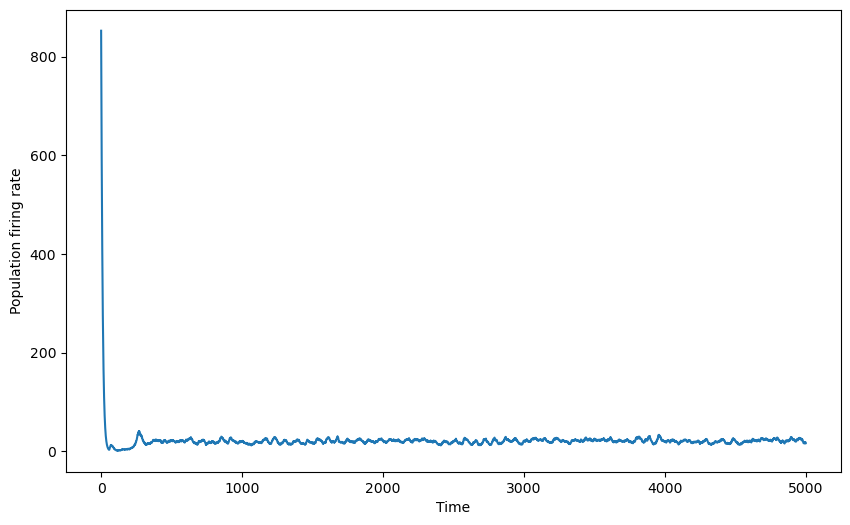

In [16]:
rate = m.population_rate(data, smooth=1.0)

plt.figure(figsize=(10, 6))
plt.plot(rate)
plt.xlabel('Time')
plt.ylabel('Population firing rate')
plt.show()

**Experiments:**

1. Experiment with different values of the excitatory and inhibitory weights and conclude on the difficult of finding E/I balance, especially when synaptic plasticity is present.